# **Notebook for Time Series Analysis**



**Authors**: Tommaso Baroni, Luca Bestagno

**Dataset**: Electric Vehicle Temperature Dataset

**Kaggle Link**: https://www.kaggle.com/datasets/wkirgsn/electric-motor-temperature

## **Context**

The data set comprises several sensor data collected from a permanent magnet synchronous motor (PMSM) deployed on a test bench. The PMSM represents a german OEM's prototype model. Test bench measurements were collected by the LEA department at Paderborn University.

## **Content**

All recordings are sampled at **2 Hz**. The data set consists of multiple measurement sessions, which can be distinguished from each other by column "profile_id". **A measurement session can be between one and six hours long**.

The motor is excited by hand-designed driving cycles denoting a reference **motor speed** and **a reference torque**.
Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque.
Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.

#### **Inspiration**

The most interesting target features are rotor temperature ("pm"), stator temperatures ("stator_*") and torque.
Especially rotor temperature and torque are not reliably and economically measurable in a commercial vehicle.

# Importing Libraries and Data Loading

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


# **COLUMNS**

**u_q**

Voltage q-component measurement in dq-coordinates (in V)

**coolant**

Coolant temperature (in °C)

**stator_winding**

Stator winding temperature (in °C) measured with thermocouples

**u_d**

Voltage d-component measurement in dq-coordinates

**stator_tooth**

Stator tooth temperature (in °C) measured with thermocouples

**motor_speed**

Motor speed (in rpm)

**i_d**

Current d-component measurement in dq-coordinates

**i_q**

Current q-component measurement in dq-coordinates

**pm**

Permanent magnet temperature (in °C) measured with thermocouples and transmitted wirelessly via a thermography unit.

**stator_yoke**

Stator yoke temperature (in °C) measured with thermocouples

**ambient**

Temperature of the environment in which the test was performed (in °C)

**torque**

Resultant torque generated by the PMSM (in Nm)



# Exploratory Data Analysis (EDA)

In [3]:
# Overview of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [4]:
#Statistical Analysis of the Dataset
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


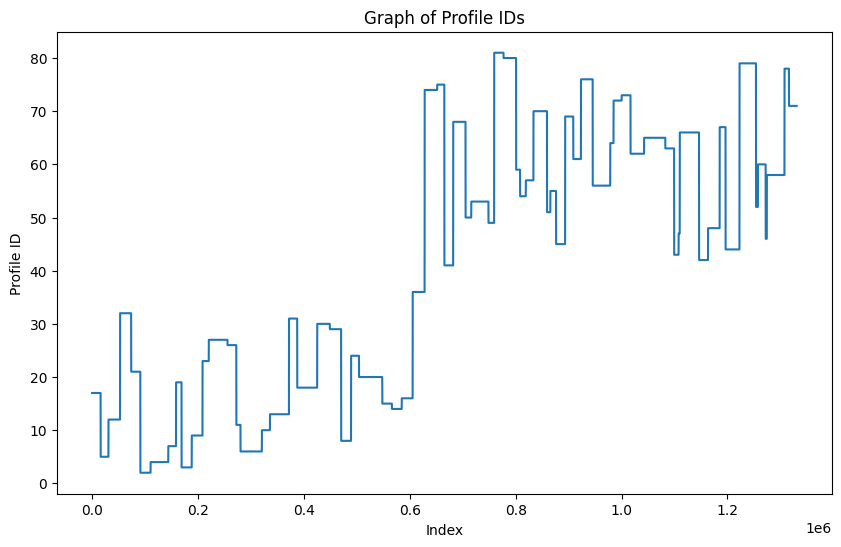

In [5]:
# Let's plot the profile ID values.

plt.figure(figsize=(10, 6))
plt.plot(df['profile_id'])
plt.title('Graph of Profile IDs')
plt.xlabel('Index')
plt.ylabel('Profile ID')
plt.show()

In [6]:
# Unique value of the measurement sessions
unique_values = df['profile_id'].unique()
print(unique_values)

[17  5 12 32 21  2  4  7 19  3  9 23 27 26 11  6 10 13 31 18 30 29  8 24
 20 15 14 16 36 74 75 41 68 50 53 49 81 80 59 54 57 70 51 55 45 69 61 76
 56 64 72 73 62 65 63 43 47 66 42 48 67 44 79 52 60 46 58 78 71]


Let's now see the session lengths

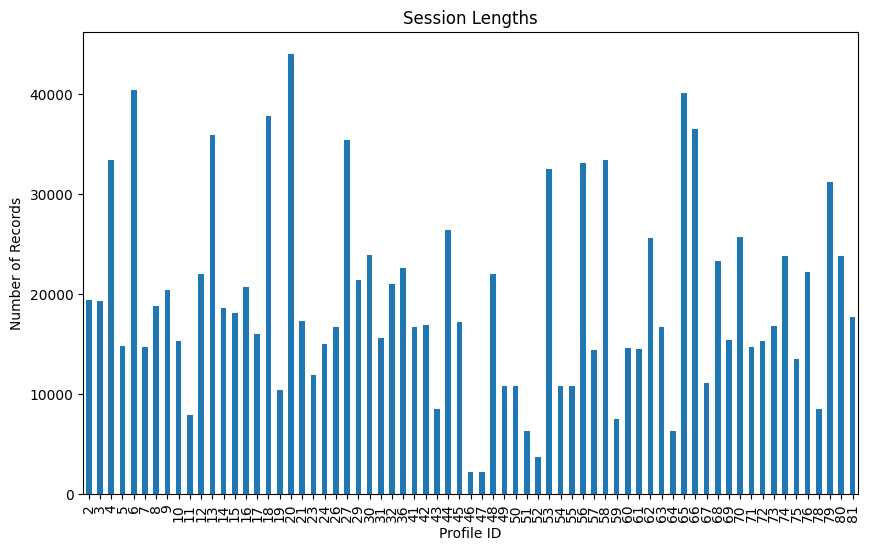

In [7]:
# Calculate the session lengths
session_lengths = df['profile_id'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
session_lengths.plot(kind='bar')
plt.title('Session Lengths')
plt.xlabel('Profile ID')
plt.ylabel('Number of Records')
plt.show()

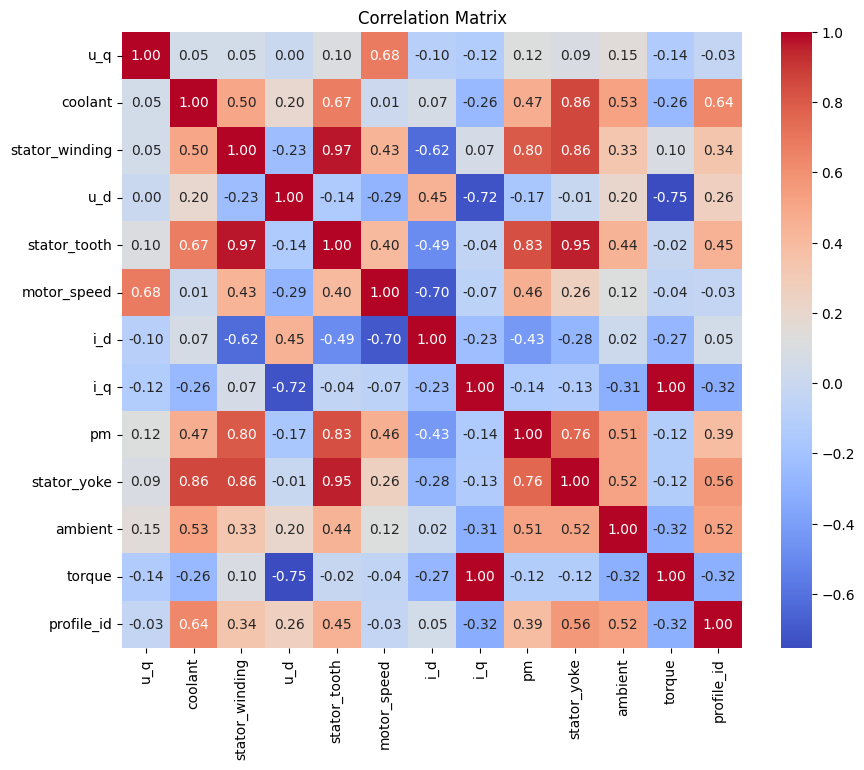

In [11]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix using seaborn's heatmap function
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

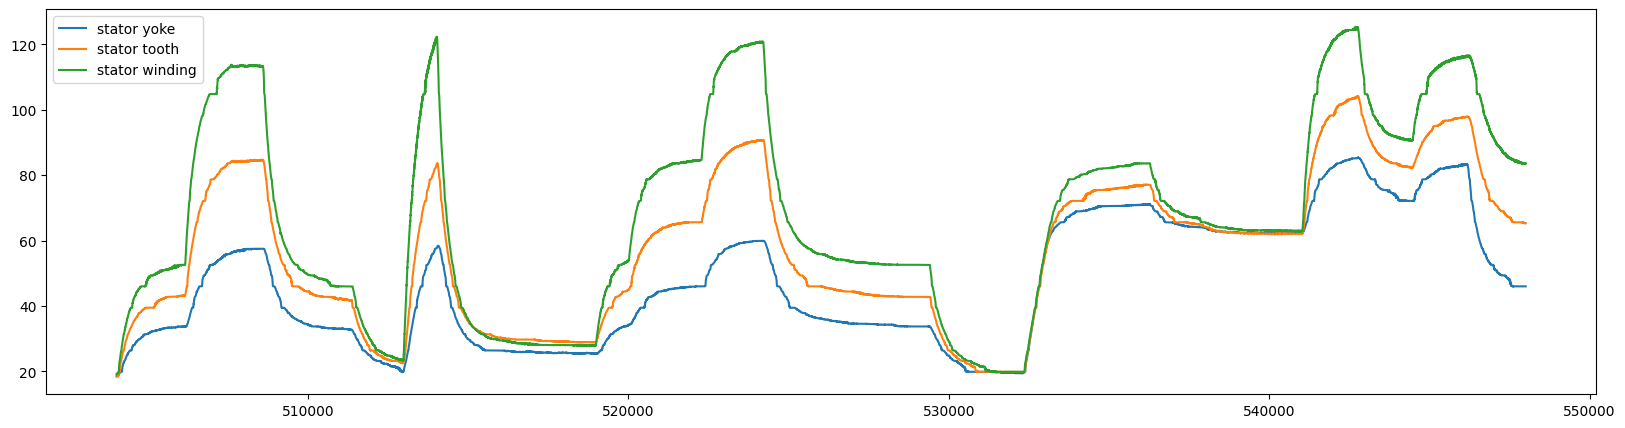

In [9]:
#visualize the correlation between the temperature stator yoke, stator tooth and stator winding
plt.figure(figsize=(20,5))
df[df['profile_id'] == 20]['stator_yoke'].plot(label = 'stator yoke')
df[df['profile_id'] == 20]['stator_tooth'].plot(label = 'stator tooth')
df[df['profile_id'] == 20]['stator_winding'].plot(label = 'stator winding')
plt.legend()

In [5]:
# This function applies z-score normalization to all the features in the dataset except from the profile id
def apply_z_score_normalization_except_profile_id(df):

    profile_id = df['profile_id']
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_to_scale)

    # Creating a new DataFrame with the scaled data
    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    # Adding the 'profile_id' column back to the scaled DataFrame
    df_scaled['profile_id'] = profile_id

    return df_scaled


# This function adds 
def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    
    exclude_columns = set(exclude_columns) | {'profile_id'}
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df

In [6]:
df_norm = apply_z_score_normalization_except_profile_id(df)

In [8]:
exclude_columns = ['stator_winding']

spans = [600]

data_df = add_ewa_features_by_profile_id(df_norm, spans, exclude_columns)

data_df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,coolant_ewa_600,u_d_ewa_600,stator_tooth_ewa_600,motor_speed_ewa_600,i_d_ewa_600,i_q_ewa_600,pm_ewa_600,stator_yoke_ewa_600,ambient_ewa_600,torque_ewa_600
0,-1.238979,-0.799812,-1.648158,0.392820,-1.681117,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,...,-0.799812,0.392820,-1.681117,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,-2.443386,-0.400838
1,-1.236150,-0.799197,-1.647959,0.393521,-1.681047,-1.184129,1.058278,-0.405867,-1.787686,-1.494323,...,-0.799810,0.392822,-1.681116,-1.184128,1.058337,-0.405855,-1.786840,-1.494244,-2.443386,-0.400836
2,-1.238757,-0.798729,-1.648064,0.392464,-1.681078,-1.184128,1.058289,-0.405854,-1.787338,-1.493755,...,-0.799807,0.392821,-1.681116,-1.184128,1.058337,-0.405855,-1.786841,-1.494242,-2.443386,-0.400836
3,-1.236180,-0.798417,-1.648285,0.393356,-1.681146,-1.184126,1.058270,-0.405836,-1.786847,-1.493529,...,-0.799802,0.392823,-1.681116,-1.184128,1.058337,-0.405855,-1.786841,-1.494240,-2.443386,-0.400834
4,-1.239442,-0.797432,-1.648303,0.393101,-1.681195,-1.184127,1.057279,-0.405455,-1.786248,-1.493738,...,-0.799794,0.392823,-1.681117,-1.184128,1.058333,-0.405854,-1.786839,-1.494238,-2.443386,-0.400833


In [9]:
# Hyperparameters (downsampling, train/dev/test-split, feature selection, ...)
downsample_rate = 4
n_dev = 2 
n_test = 1
window_len = 64
features = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q', 'u_s', 'i_s', 's_el']
feature_len = len(features)
target = ['stator_winding']

In [10]:
IDs = np.array(data_df['profile_id'].unique())

In [11]:
# Creates single sample array of shape (1, T, n)
def get_single_sample(df, n_feat, sample_len, downsample_rate=1):
    
    # Get new length for downsampling
    new_len = int(np.floor((max_len + downsample_rate - 1) / downsample_rate) * downsample_rate)
    
    # Convert df to numpy array of shape (1, T, n)
    arr = df.to_numpy()
    arr = np.expand_dims(arr, axis=0)
    
    # Zero-pad to sample_len at the end of the array
    _arr = np.zeros((1, new_len - np.size(arr, 1), n_feat))
    sample = np.concatenate((arr, _arr), axis=1)
    
    # Get sample_weights (zero-padded elements should have zero weight)
    weights = np.concatenate((np.ones(arr.shape), np.zeros(_arr.shape)), axis=1)
    weights = weights[:,:,0]
    
    # Perform Downsampling
    dwn_sample = []
    dwn_weights = []
    for d in np.arange(1,downsample_rate+1):
        dwn_sample.append(sample[:,(-1+d)::downsample_rate,:])
        dwn_weights.append(weights[:,(-1+d)::downsample_rate])
    
    sample = np.concatenate(dwn_sample, axis=0)
    weights = np.concatenate(dwn_weights, axis=0)
        
    return sample, weights


## Derive additional features, create batches and train/dev/test-split

In [12]:
# Derive additional features: Current and voltage magnitude & electrical apparent power

data_df['u_s'] = np.sqrt(data_df['u_d']**2 + data_df['u_q']**2)
data_df['i_s'] = np.sqrt(data_df['i_d']**2 + data_df['i_q']**2)
data_df['s_el'] = 1.5 * data_df['u_s'] * data_df['i_s']

data_df.head(10)

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,motor_speed_ewa_600,i_d_ewa_600,i_q_ewa_600,pm_ewa_600,stator_yoke_ewa_600,ambient_ewa_600,torque_ewa_600,u_s,i_s,s_el
0,-1.238979,-0.799812,-1.648158,0.392820,-1.681117,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,...,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,-2.443386,-0.400838,1.299760,1.133488,2.209894
1,-1.236150,-0.799197,-1.647959,0.393521,-1.681047,-1.184129,1.058278,-0.405867,-1.787686,-1.494323,...,-1.184128,1.058337,-0.405855,-1.786840,-1.494244,-2.443386,-0.400836,1.297277,1.133438,2.205574
2,-1.238757,-0.798729,-1.648064,0.392464,-1.681078,-1.184128,1.058289,-0.405854,-1.787338,-1.493755,...,-1.184128,1.058337,-0.405855,-1.786841,-1.494242,-2.443386,-0.400836,1.299441,1.133443,2.209263
3,-1.236180,-0.798417,-1.648285,0.393356,-1.681146,-1.184126,1.058270,-0.405836,-1.786847,-1.493529,...,-1.184128,1.058337,-0.405855,-1.786841,-1.494240,-2.443386,-0.400834,1.297254,1.133418,2.205498
4,-1.239442,-0.797432,-1.648303,0.393101,-1.681195,-1.184127,1.057279,-0.405455,-1.786248,-1.493738,...,-1.184128,1.058333,-0.405854,-1.786839,-1.494238,-2.443386,-0.400833,1.300287,1.132357,2.208583
5,-1.240978,-0.795389,-1.648492,0.398513,-1.681229,-1.184124,1.048819,-0.402205,-1.785816,-1.493878,...,-1.184128,1.058301,-0.405841,-1.786836,-1.494237,-2.443386,-0.400820,1.303395,1.123294,2.196144
6,-1.243562,-0.793545,-1.648580,0.402154,-1.681147,-1.184128,1.042782,-0.399846,-1.785660,-1.493974,...,-1.184128,1.058250,-0.405821,-1.786832,-1.494236,-2.443387,-0.400800,1.306972,1.116813,2.189464
7,-1.245945,-0.792666,-1.648304,0.404630,-1.681081,-1.184128,1.038427,-0.398196,-1.785746,-1.494338,...,-1.184128,1.058184,-0.405796,-1.786828,-1.494236,-2.443387,-0.400775,1.310002,1.112156,2.185390
8,-1.245237,-0.792084,-1.648198,0.407032,-1.681171,-1.184129,1.035314,-0.396992,-1.786160,-1.494725,...,-1.184128,1.058108,-0.405767,-1.786826,-1.494238,-2.443387,-0.400744,1.310073,1.108818,2.178949
9,-1.248569,-0.791429,-1.648529,0.407544,-1.681377,-1.184130,1.033098,-0.396117,-1.786888,-1.494985,...,-1.184128,1.058024,-0.405735,-1.786826,-1.494241,-2.443387,-0.400713,1.313399,1.106435,2.179787


In [13]:
features = data_df.columns

features = [elem for elem in features if elem != 'stator_winding']
features = [elem for elem in features if elem != 'profile_id']
feature_len = len(features)

print(features)

print(len(features))

['u_q', 'coolant', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque', 'u_q_ewa_600', 'coolant_ewa_600', 'u_d_ewa_600', 'stator_tooth_ewa_600', 'motor_speed_ewa_600', 'i_d_ewa_600', 'i_q_ewa_600', 'pm_ewa_600', 'stator_yoke_ewa_600', 'ambient_ewa_600', 'torque_ewa_600', 'u_s', 'i_s', 's_el']
25


In [14]:
# Prepare Data for use with LSTMs: Data needs to be in shape (m, T, n)

# get maximum length, select features and target
max_len = data_df.groupby(['profile_id']).size().max()

# Prepare index for faster iteration
iter_df = data_df.copy() # copy increases memory use, but avoids errors when executed twice. Better solution?
iter_df['idx'] = data_df.index
iter_df.set_index(['profile_id', 'idx'], inplace = True)

# create (m, T, n) array for X_values, sample_weights and Y_values
batch_samples_X = []
batch_weights_X = []
batch_samples_Y = []

for pid in IDs:
    # select profile
    df = iter_df.loc[pid]
    # get X samples and weights
    sample, weights = get_single_sample(df[features], 25, max_len, downsample_rate)
    batch_samples_X.append(sample)
    batch_weights_X.append(weights)    
    # get Y samples
    sample, _ = get_single_sample(df[target], 1, max_len, downsample_rate)
    batch_samples_Y.append(sample)
    
X_vals = np.concatenate(batch_samples_X, axis=0)
X_weights = np.concatenate(batch_weights_X, axis=0)
Y_vals = np.concatenate(batch_samples_Y, axis=0)

print('Shape of batches')
print('X_vals:    ', X_vals.shape)
print('X_weights: ', X_weights.shape)
print('Y_vals:    ', Y_vals.shape)

Shape of batches
X_vals:     (276, 10993, 25)
X_weights:  (276, 10993)
Y_vals:     (276, 10993, 1)


In [15]:
# Create train-dev-test-split for LSTMs
# (when cycles are downsampled, all downsampled parts should belong to the same set)
X_train = X_vals[:-(n_dev+n_test)*downsample_rate,:,:]
X_train_weights = X_weights[:-(n_dev+n_test)*downsample_rate,:]
Y_train = Y_vals[:-(n_dev+n_test)*downsample_rate,:,:]

X_dev = X_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]
X_dev_weights = X_weights[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:]
Y_dev = Y_vals[-((n_dev+n_test)*downsample_rate):-(n_test)*downsample_rate,:,:]

X_test = X_vals[-((n_test)*downsample_rate):,:,:]
X_test_weights = X_weights[-((n_test)*downsample_rate):,:]
Y_test = Y_vals[-((n_test)*downsample_rate):,:,:]

print('Shape of train-test-split')
print('train (X, weights, Y): ', X_train.shape, X_train_weights.shape, Y_train.shape)
print('dev (X, weights, Y):   ', X_dev.shape, X_dev_weights.shape, Y_dev.shape)
print('test (X, weights, Y):  ', X_test.shape, X_test_weights.shape, Y_test.shape)


# Normalization / Scaling 
# >> optional, values are already at a similar scale

# EWMA filtering 
# >> optional, this de-noises the data which helps with learning and prediction
# >> however, real sensor data is also noisy, so the task is harder and more realistic with noise.

Shape of train-test-split
train (X, weights, Y):  (264, 10993, 25) (264, 10993) (264, 10993, 1)
dev (X, weights, Y):    (8, 10993, 25) (8, 10993) (8, 10993, 1)
test (X, weights, Y):   (4, 10993, 25) (4, 10993) (4, 10993, 1)


# Neural Network Training
* LSTM - A simple (sequential) LSTM architecture.
* ResLSTM - LSTM with residual connections.
* TCN - Temporal Convolutional Network with residual connections.

## Hyperparameters and shared utils for model training
To keep things simple the same hyperparameters are used for all models that are being compared (if applicable). The number of units in the LSTM units is equal to the number of filters used for the TCN. Also, the model architecture is kept similar: All models share a final dense network consisting of three layers with descending number of units. For residual networks, two blocks are used for both LSTM and TCN. The same learning and dropout rate is used, however spatial dropout is only applied to TCNs.

In [16]:
n_epochs = 25
lr = 0.01
lr_decay = 1e-2
dropout_rate = 0.1
spatial_dropout = 0.7
n_units = 32
n_dense_in = 16
n_dense_mid = 8
n_dense_out = 1
len_kernel = 4

In [17]:
# Plots the loss over all epochs and a zoom on the last 20 epochs.
def plot_learning_curves(history, descr=' '):

    # get results
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss)) 
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # loss
    axes[0].plot(epochs, loss, 'r')
    axes[0].plot(epochs, val_loss, 'b')
    axes[0].set_title('Loss - Train vs. Validation')
    axes[0].legend(['Train', 'Validation'])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('loss')
    
    # mse
    axes[1].plot(epochs[n_epochs-20:], loss[n_epochs-20:], 'r')
    axes[1].plot(epochs[n_epochs-20:], val_loss[n_epochs-20:], 'b')
    axes[1].set_title('Loss - Zoom to last 20 epochs')
    axes[1].legend(['Train', 'Validation'])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('loss')
    axes[1].set_xticks(np.arange(n_epochs-20, n_epochs, step=2))
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')
    
    return

## SimpleLSTM
First, let's start with a simple LSTM. There should be about 50k trained parameters. This number is close to the simplest model used in the research paper (though this one here uses no residual connections). According to the research findings it should already reach a descent performance in predicting the electric motor temperature.

In [16]:
simple_lstm = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(n_units, return_sequences=True, input_shape=[None, feature_len]),
  tf.keras.layers.Dense(n_dense_mid, activation="relu"),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(n_dense_out),
])

simple_lstm.summary()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, 
                                     decay=lr_decay,
                                     beta_1=0.9, beta_2=0.999, amsgrad=False)

simple_lstm.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mse'],
              sample_weight_mode='temporal')

print('---- training in progress ----')

history = simple_lstm.fit(x=X_train, y=Y_train, 
                          validation_data=(X_dev, Y_dev, X_dev_weights), 
                          sample_weight=X_train_weights, 
                          epochs=n_epochs,
                          verbose=1)

print('--- done ---')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          7424      
                                                                 
 dense (Dense)               (None, None, 8)           264       
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 dense_1 (Dense)             (None, None, 1)           9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
_________________________________________________________________
---- training in progress ----
Epoch 1/25


2023-12-15 20:55:56.000742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 20:55:56.001897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 20:55:56.002370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/9 [==>...........................] - ETA: 23s - loss: 0.4200 - mse: 0.4200

KeyboardInterrupt: 

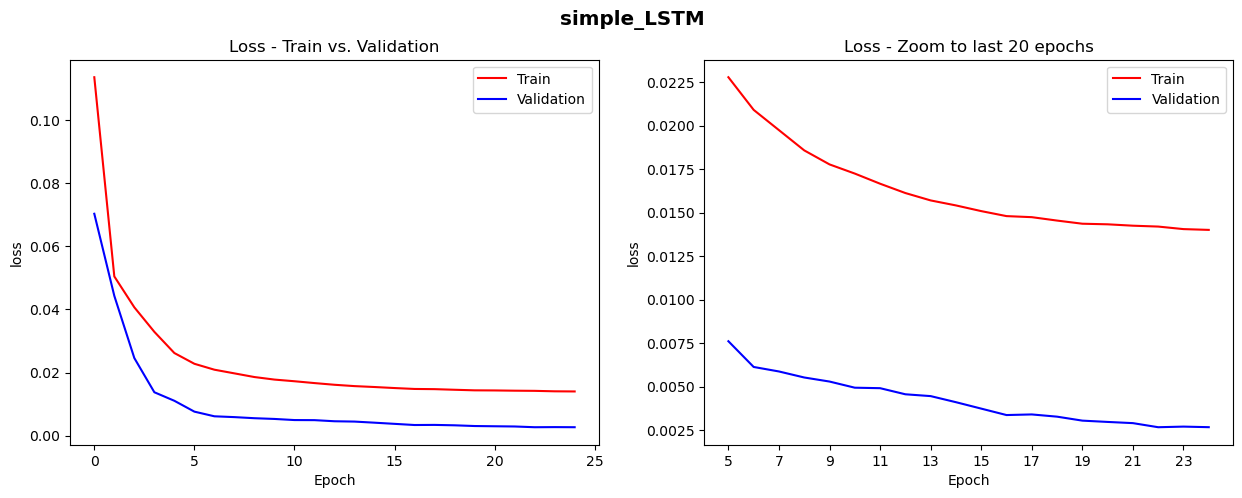

In [123]:
plot_learning_curves(history, descr='simple_LSTM')

# Model Evaluation
* Optimizing metric is MSE (mean squared error).
* An arbitrary load cycle from the training set is plotted to show and validate training results.
* The worst load cycle from the dev set is plotted for hyperparameter tuning.

## Shared utils for evaluation

In [18]:
# This function makes a prediction on a given X of shape (1,Tx,1).
# The first skip_values are truncated, because initial temperature states may have large error.
# Also, only "not-zero-padded" part of the sequence is taken into account (-> sample_weight = 1).
def eval_model(model, X, Y, weights, skip_values=10, scaler=None):
    # prepare data for prediction
    end_sequence = np.where(weights==0)[1][0] # get "real" (= not-zero-padded) end of sequence
    X_pred = X[:,:end_sequence,:]
    Y_truth = Y[0,:end_sequence,0]

    # predict (and rescale if necessary)
    Y_pred = model.predict(X_pred)
    if scaler:
        Y_pred = scaler.inverse_transform(Y_pred)     
    Y_pred = Y_pred[0,:,0]
    
    # skip the first few values (large errors due to initialization phase)
    Y_pred = Y_pred[skip_values:]
    Y_truth = Y_truth[skip_values:]
        
    # calculate errors
    abs_error = np.abs(Y_pred-Y_truth)
    mse_error = np.mean(abs_error**2)    
    
    return Y_pred, Y_truth, abs_error, mse_error

# This function outputs a plot showing the prediction vs. ground truth and the corresponding error.
def plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr=' '):

    fig, axes = plt.subplots(1, 2, sharex = True, figsize=(15, 5))

    # Temperature values
    axes[0].plot(Y_truth, 'r')
    axes[0].plot(Y_pred, 'b')
    axes[0].set_title('Prediction vs. ground truth')
    axes[0].legend(['Truth', 'Prediction'])
    axes[0].set_xlabel('sample')
    axes[0].set_ylabel('Temperature')
    
    # Error
    axes[1].plot(abs_error, 'r')
    axes[1].set_title('Error (total MSE: {:.5f})'.format(mse_error))
    axes[1].set_xlabel('sample')
    axes[1].set_ylabel('Error')
    
    fig.suptitle(descr, fontsize="x-large", fontweight='bold')

    return

# This function finds the load cycle with the highest mse.
def get_worst_cycle(model, X, Y, weights):
    
    highest_mse = 0
    worst_pid = 0

    for pid in np.arange(0,X.shape[0]):
        X_pred = X[pid:pid+1,:,:]
        Y_truth = Y[pid:pid+1,:,:]
        X_weights = weights[pid:pid+1,:]
        Y_pred, Y_truth, abs_error, mse_error = eval_model(model, X_pred, Y_truth, X_weights)
        if mse_error > highest_mse:
            highest_mse = mse_error
            worst_pid = pid
    
    return worst_pid

## SimpleLSTM
In accordance to the research paper, a simple model with relatively few parameters can already reach descent accuracy of the temperature estimation.

In [17]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(simple_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='simple_LSTM - TRAIN SET EXAMPLE')

NameError: name 'simple_lstm' is not defined

1/1 [==============================] - 0s 272ms/step


2023-12-15 17:27:01.893801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 17:27:01.894426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 17:27:01.894930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 116ms/step


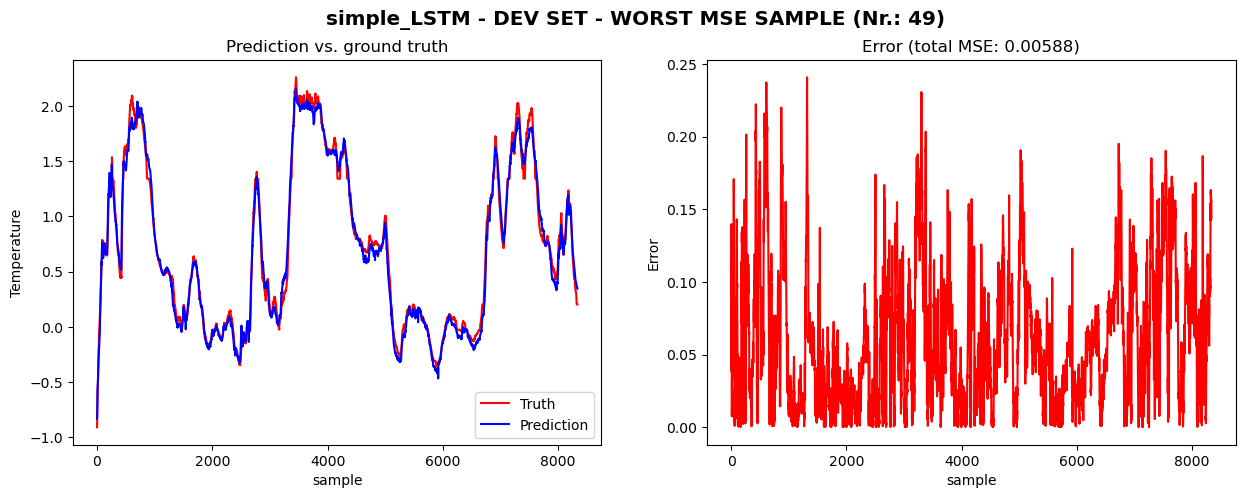

In [126]:
# Plot worst load cycle from dev set (highest mse)

worst_pid = get_worst_cycle(simple_lstm, X_dev, Y_dev, X_dev_weights)

X_pred_dev = X_dev[worst_pid:worst_pid+1,:,:]
Y_truth_dev = Y_dev[worst_pid:worst_pid+1,:,:]
weights_dev = X_dev_weights[worst_pid:worst_pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(simple_lstm, X_pred_dev, Y_truth_dev, weights_dev)        
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='simple_LSTM - DEV SET - WORST MSE SAMPLE (Nr.: ' + str(pid) +')')

## ResLSTM
The ResLSTM adds residual connections to the architecture using keras functional API. The Dense layers and number of nodes of the LSTMs will be the same as the simple_LSTM model. To reduce computational cost, the number of parameters is about 120k where in the original research paper >850k parameters were trained.

In [27]:

# Define the learning rate schedule
initial_learning_rate = lr  # Set your initial learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,  # Adjust as per your requirements
    decay_rate=0.96,     # Adjust the decay rate as needed
    staircase=True)

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Build your model as before
inputs = tf.keras.layers.Input(shape=[None, feature_len])

# Single LSTM layer
out_1 = tf.keras.layers.LSTM(n_units, return_sequences=True)(inputs)

# Simplified Dense Layers
x = tf.keras.layers.Dense(n_dense_in, activation="relu")(out_1)
# Optional: Dropout layer if overfitting is observed
x = tf.keras.layers.Dropout(dropout_rate)(x)
y = tf.keras.layers.Dense(n_dense_out)(x)

# Create model
simplified_lstm = tf.keras.models.Model(inputs=[inputs], outputs=y)

# Compile the model
res_lstm = tf.keras.models.Model(inputs=[inputs], outputs=y)
res_lstm.summary()



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 25)]        0         
                                                                 
 lstm_5 (LSTM)               (None, None, 32)          7424      
                                                                 
 dense_5 (Dense)             (None, None, 16)          528       
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 dense_6 (Dense)             (None, None, 1)           17        
                                                                 
Total params: 7,969
Trainable params: 7,969
Non-trainable params: 0
_________________________________________________________________


2023-12-15 21:13:30.683623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:13:30.684238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:13:30.684635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [28]:
res_lstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Train the model
history = res_lstm.fit(
    x=X_train, 
    y=Y_train, 
    validation_data=(X_dev, Y_dev, X_dev_weights), 
    sample_weight=X_train_weights, 
    epochs=n_epochs,
    verbose=1)

print('--- Training complete ---')

Epoch 1/25


2023-12-15 21:13:39.414151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:13:39.415183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:13:39.415752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - ETA: 0s - loss: 0.1796 - mse: 0.1833WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


2023-12-15 21:13:57.598181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:13:57.598909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:13:57.599420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 19s 2s/step - loss: 0.1796 - mse: 0.1833 - val_loss: 0.0574 - val_mse: 0.0575
Epoch 2/25
9/9 [==============================] - ETA: 0s - loss: 0.0449 - mse: 0.0457WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0449 - mse: 0.0457 - val_loss: 0.0213 - val_mse: 0.0219
Epoch 3/25
9/9 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0281WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0269 - mse: 0.0281 - val_loss: 0.0130 - val_mse: 0.0146
Epoch 4/25
9/9 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0219WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0202 - mse: 0.0219 - val_loss: 0.0118 - val_mse: 0.0133
Epoch 5/25
9/9 [==============================] - ETA: 0s - loss: 0.0164 - mse: 0.0184WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0164 - mse: 0.0184 - val_loss: 0.0068 - val_mse: 0.0086
Epoch 6/25
9/9 [==============================] - ETA: 0s - loss: 0.0147 - mse: 0.0164WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0147 - mse: 0.0164 - val_loss: 0.0067 - val_mse: 0.0077
Epoch 7/25
9/9 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0137WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0125 - mse: 0.0137 - val_loss: 0.0050 - val_mse: 0.0056
Epoch 8/25
9/9 [==============================] - ETA: 0s - loss: 0.0113 - mse: 0.0120WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0113 - mse: 0.0120 - val_loss: 0.0043 - val_mse: 0.0047
Epoch 9/25
9/9 [==============================] - ETA: 0s - loss: 0.0105 - mse: 0.0111WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0105 - mse: 0.0111 - val_loss: 0.0034 - val_mse: 0.0036
Epoch 10/25
9/9 [==============================] - ETA: 0s - loss: 0.0100 - mse: 0.0103WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0100 - mse: 0.0103 - val_loss: 0.0033 - val_mse: 0.0035
Epoch 11/25
9/9 [==============================] - ETA: 0s - loss: 0.0095 - mse: 0.0098WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0095 - mse: 0.0098 - val_loss: 0.0035 - val_mse: 0.0036
Epoch 12/25
9/9 [==============================] - ETA: 0s - loss: 0.0093 - mse: 0.0095WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0093 - mse: 0.0095 - val_loss: 0.0029 - val_mse: 0.0030
Epoch 13/25
9/9 [==============================] - ETA: 0s - loss: 0.0090 - mse: 0.0092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0090 - mse: 0.0092 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 14/25
9/9 [==============================] - ETA: 0s - loss: 0.0087 - mse: 0.0088WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0087 - mse: 0.0088 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 15/25
9/9 [==============================] - ETA: 0s - loss: 0.0084 - mse: 0.0085WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 18s 2s/step - loss: 0.0084 - mse: 0.0085 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 16/25
9/9 [==============================] - ETA: 0s - loss: 0.0083 - mse: 0.0084WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0083 - mse: 0.0084 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 17/25
9/9 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0081 - mse: 0.0083 - val_loss: 0.0027 - val_mse: 0.0028
Epoch 18/25
9/9 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0081 - mse: 0.0082 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 19/25
9/9 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0081 - mse: 0.0082 - val_loss: 0.0028 - val_mse: 0.0029
Epoch 20/25
9/9 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0081 - mse: 0.0083 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 21/25
9/9 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0080 - mse: 0.0082 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 22/25
9/9 [==============================] - ETA: 0s - loss: 0.0081 - mse: 0.0083WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0081 - mse: 0.0083 - val_loss: 0.0020 - val_mse: 0.0021
Epoch 23/25
9/9 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0080 - mse: 0.0082 - val_loss: 0.0026 - val_mse: 0.0027
Epoch 24/25
9/9 [==============================] - ETA: 0s - loss: 0.0080 - mse: 0.0082WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0080 - mse: 0.0082 - val_loss: 0.0023 - val_mse: 0.0024
Epoch 25/25
9/9 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.


9/9 [==============================] - 19s 2s/step - loss: 0.0079 - mse: 0.0081 - val_loss: 0.0019 - val_mse: 0.0020
--- Training complete ---


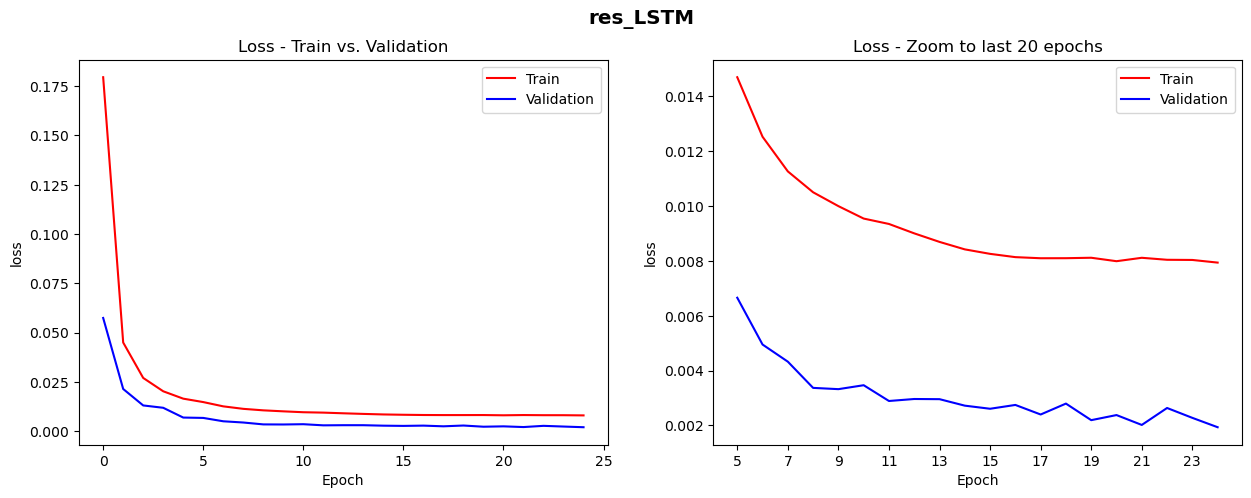

In [29]:
plot_learning_curves(history, descr='res_LSTM')

2023-12-15 21:21:29.879602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:21:29.880838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:21:29.881568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 571ms/step


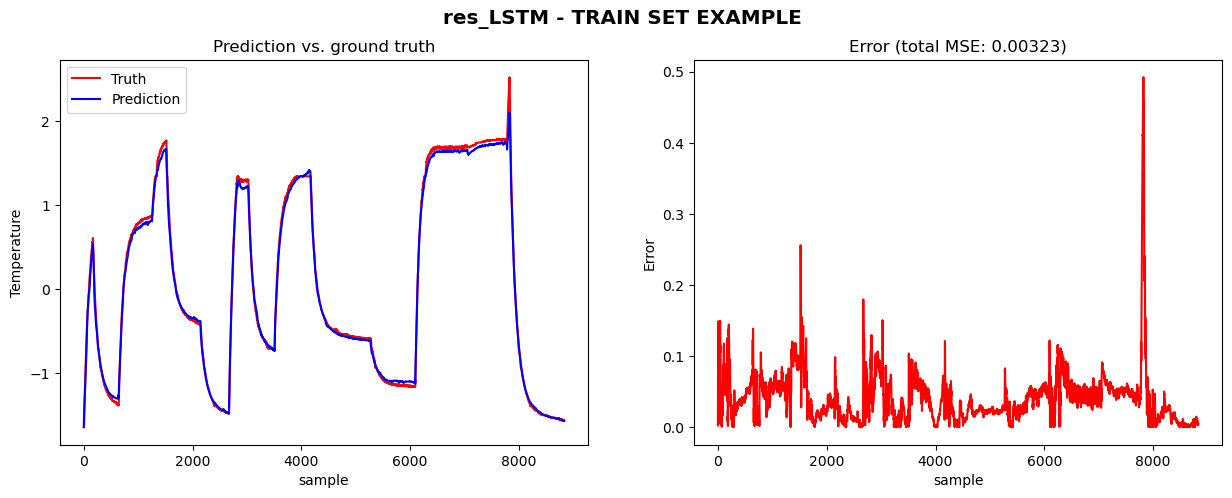

In [30]:
# Plot prediction vs. ground truth for one sample of training set

# training set
pid = 49 # basically a random load cycle
X_pred_train = X_train[pid:pid+1,:,:]
Y_truth_train = Y_train[pid:pid+1,:,:]
weights_train = X_train_weights[pid:pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(res_lstm, X_pred_train, Y_truth_train, weights_train)
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='res_LSTM - TRAIN SET EXAMPLE')

2023-12-15 21:21:33.644069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-15 21:21:33.645160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-15 21:21:33.645784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 131ms/step


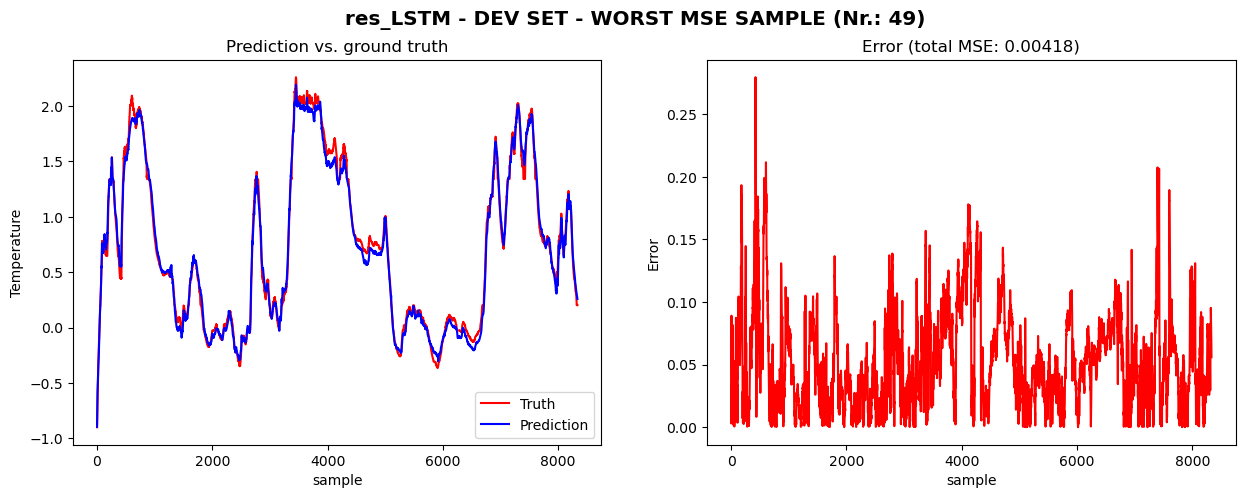

In [31]:
# Plot worst load cycle from dev set (highest mse)

worst_pid = get_worst_cycle(res_lstm, X_dev, Y_dev, X_dev_weights)

X_pred_dev = X_dev[worst_pid:worst_pid+1,:,:]
Y_truth_dev = Y_dev[worst_pid:worst_pid+1,:,:]
weights_dev = X_dev_weights[worst_pid:worst_pid+1,:]
Y_pred, Y_truth, abs_error, mse_error = eval_model(res_lstm, X_pred_dev, Y_truth_dev, weights_dev)        
plot_prediction(Y_pred, Y_truth, abs_error, mse_error, descr='res_LSTM - DEV SET - WORST MSE SAMPLE (Nr.: ' + str(pid) +')')